In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn

In [2]:
method_replacement_dict = {"difference": "Difference",
                           "initial": "Initial Parameters",
                           "late_em": "Late EM",
                           "pure_competency": "Pure Competency", 
                           "real_early": "Real early Param."}


def parameter_table_model(df, latent_dimension=2, item_dimension=20, aggfunc="median", caption="", decimals=3):
    sub_df = df[(df["latent_dimension"] == 2) & (df["item_dimension"] == 20)]
    n =np.min(sub_df.groupby(["latent_dimension", "item_dimension", "sample_size"])["method"].value_counts())
    rmse_columns = ["method", "sample_size", "rmse_early_A", "rmse_early_delta", "rmse_early_sigma",
                    "rmse_late_A", "rmse_late_delta", "rmse_late_sigma", "rmse_psi"]
    sub_df = sub_df[rmse_columns]
    columns = ["Method","Sample size", "$A^e$", "$\Delta^e$", "$\Sigma^e$",
                       "$A^l$", "$\Delta^l$", "$\Sigma^l$", "$\Psi$"]
    sub_df.columns = columns
    sub_df = sub_df.replace(method_replacement_dict)
    parameter_table = sub_df.groupby(["Sample size", "Method"]).agg(aggfunc)
    parameter_table = np.round(parameter_table, decimals)
    print(parameter_table.to_latex(bold_rows=True, multirow=True, 
                                   caption=caption+", n={0}".format(n), 
                                   position="H", escape=False))
    return(parameter_table)

In [3]:
def single_metric_table(df, metric, aggfunc="median", latex=True, decimals=3, caption=""):
    df = df.replace(method_replacement_dict)
    n = np.min(df.groupby(["latent_dimension", "item_dimension", "sample_size"])["method"].value_counts())
    table = pd.crosstab(index=[df["sample_size"], df["method"]],
                columns=[df["latent_dimension"], df["item_dimension"]], 
                values=df[metric], 
                aggfunc=aggfunc)
    table = np.round(table, decimals)
    if latex:
        print(table.to_latex(bold_rows=True, multirow=True, 
                             caption=caption+", n={0}".format(n),
                             position="H"))
    return(table)

In [4]:
def model_boxplot(df, metric='rmse_psi', latent_dimension=2, item_dimension=20, 
                  title="",
                  methods=["late_em", "real_early", "pure_competency", "initial", "difference"]):
    sub_df = df[(df["latent_dimension"] == 2) & (df["item_dimension"] == 20)]
    sub_df = sub_df[(sub_df["method"].isin(methods))]
    sub_df = sub_df.replace(method_replacement_dict)
    n =np.min(sub_df.groupby(["latent_dimension", "item_dimension", "sample_size"])["method"].value_counts())
    fig = plt.gcf()
    fig.set_dpi(100)
    fig.set_size_inches(10, 5)
    plt.title(title+", n={0}".format(n))
    sn.boxplot(x=sub_df[metric], hue=sub_df["sample_size"].astype("str"), y=sub_df["method"],
               orient="h")

# Results

## Simulatuion Results

### Full Q Matrix

In [5]:
full_Q_df = pd.read_csv("results/full_q.csv")
full_Q_df

,latent_dimension,item_dimension,sample_size,key,method,early_runtime,late_runtime,early_steps,late_steps,early_l_optimal,...,rmse_early_A,rmse_early_delta,rmse_early_sigma,rmse_late_A,rmse_late_delta,rmse_psi,rmse_late_sigma,rmse_theta,rmse_gain_estimated,rmse_gain_pred_train
0,2,10,30,2022-11-10 00:07:31.028317,late_em,3.23,11.33,10.0,8.0,-185.38,...,1.165435,0.990497,0.024537,1.559702,1.809461,0.234788,0.215032,0.688319,0.794077,0.727562
1,2,10,30,2022-11-10 00:07:31.028317,initial,0.00,0.00,0.0,0.0,-184.83,...,1.813287,0.597970,0.263114,0.694863,1.310203,0.263770,0.354906,0.734315,0.956372,0.741465
2,2,10,30,2022-11-10 00:07:31.028317,difference,2.30,2.82,8.0,9.0,-185.40,...,1.272744,0.822523,0.143401,1.260802,1.624896,0.302993,0.433466,0.682575,1.075948,0.814390
3,2,10,30,2022-11-10 00:07:31.028317,real_early,NaN,28.09,NaN,14.0,NaN,...,NaN,NaN,NaN,8.754521,6.283983,0.295779,0.428182,0.000000,0.796959,0.770830
4,2,10,30,2022-11-10 00:07:31.028317,pure_competency,2.79,11.41,10.0,9.0,-184.90,...,1.397755,1.105351,0.090439,1.471871,1.689261,0.370686,0.630311,0.714685,0.893160,0.810266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,2,20,200,2022-11-10 16:57:31.592268,late_em,4.74,96.37,6.0,9.0,-1908.04,...,0.448038,0.221214,0.008768,1.141497,1.486433,0.217817,0.560029,0.423641,0.657777,0.862156
516,2,20,200,2022-11-10 16:57:31.592268,initial,0.00,0.00,0.0,0.0,-1908.52,...,0.976252,0.434234,0.057276,1.491378,1.378554,0.365281,0.385208,0.479337,0.794714,0.843230
517,2,20,200,2022-11-10 16:57:31.592268,difference,5.80,7.38,7.0,8.0,-1909.29,...,0.422982,0.278466,0.010677,0.610179,0.577838,0.256630,0.075243,0.422943,0.641887,1.081775
518,2,20,200,2022-11-10 16:57:31.592268,real_early,NaN,105.38,NaN,9.0,NaN,...,NaN,NaN,NaN,1.124568,1.440617,0.344547,0.659011,0.000000,0.577755,0.906219


In [6]:
parameter_table_model(full_Q_df)

\begin{table}[H]
\centering
\caption{, n=8}
\begin{tabular}{llrrrrrrr}
\toprule
    &                   &  $A^e$ &  $\Delta^e$ &  $\Sigma^e$ &  $A^l$ &  $\Delta^l$ &  $\Sigma^l$ &  $\Psi$ \\
\textbf{Sample size} & \textbf{Method} &        &             &             &        &             &             &         \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  2.389 &       1.624 &       0.069 &  1.969 &       1.789 &       0.226 &   0.248 \\
    & \textbf{Initial Parameters} &  1.442 &       0.585 &       0.104 &  1.391 &       1.431 &       0.354 &   0.307 \\
    & \textbf{Late EM} &  2.367 &       1.567 &       0.057 &  3.730 &       2.168 &       0.247 &   0.289 \\
    & \textbf{Pure Competency} &  2.449 &       1.628 &       0.249 &  2.534 &       2.450 &       0.561 &   0.362 \\
    & \textbf{Real early Param.} &    NaN &         NaN &         NaN &  4.574 &       2.781 &       0.474 &   0.353 \\
\cline{1-9}
\multirow{5}{*}{\textbf{100}} & \textbf{Difference} & 

C:\Users\Jesper\AppData\Local\Temp\ipykernel_19308\150259998.py:20: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(parameter_table.to_latex(bold_rows=True, multirow=True,


$A^e$  $\Delta^e$  $\Sigma^e$  $A^l$  \
Sample size Method                                                     
30          Difference          2.389       1.624       0.069  1.969   
            Initial Parameters  1.442       0.585       0.104  1.391   
            Late EM             2.367       1.567       0.057  3.730   
            Pure Competency     2.449       1.628       0.249  2.534   
            Real early Param.     NaN         NaN         NaN  4.574   
100         Difference          0.683       0.468       0.019  0.724   
            Initial Parameters  1.397       0.522       0.185  1.375   
            Late EM             0.699       0.466       0.018  0.863   
            Pure Competency     0.675       0.467       0.169  0.676   
            Real early Param.     NaN         NaN         NaN  0.799   
200         Difference          0.453       0.279       0.045  0.690   
            Initial Parameters  1.224       0.502       0.092  1.425   
            Late EM             0.464       0.304       0.056  0.829   
            Pure Competency     0.448       0.260       0.275  0.657   
            Real early Param.     NaN         NaN         NaN  1.015   

                                $\Delta^l$  $\Sigma^l$  $\Psi$  
Sample size Method                                              
30          Difference               1.789       0.226   0.248  
            Initial Parameters       1.431       0.354   0.307  
            Late EM                  2.168       0.247   0.289  
            Pure Competency          2.450       0.561   0.362  
            Real early Param.        2.781       0.474   0.353  
100         Difference               0.653       0.165   0.244  
            Initial Parameters       1.620       0.357   0.282  
            Late EM                  1.016       0.431   0.289  
            Pure Competency          1.470       0.721   0.411  
            Real early Param.        1.146       0.615   0.335  
200         Difference               0.491       0.147   0.216  
            Initial Parameters       1.534       0.390   0.286  
            Late EM                  1.002       0.424   0.244  
            Pure Competency          1.195       0.667   0.376  
            Real early Param.        0.960       0.483   0.355

In [7]:
single_metric_table(full_Q_df, "rmse_psi", caption="RMSE for Correlations $\Psi$")

\begin{table}[H]
\centering
\caption{RMSE for Correlations $\Psi$, n=4}
\begin{tabular}{llrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     10 &     20 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  0.339 &  0.248 &  0.358 &  0.326 \\
    & \textbf{Initial Parameters} &  0.319 &  0.307 &  0.283 &  0.288 \\
    & \textbf{Late EM} &  0.310 &  0.289 &  0.332 &  0.337 \\
    & \textbf{Pure Competency} &  0.426 &  0.362 &  0.321 &  0.400 \\
    & \textbf{Real early Param.} &  0.324 &  0.353 &  0.399 &  0.337 \\
\cline{1-6}
\multirow{5}{*}{\textbf{100}} & \textbf{Difference} &  0.335 &  0.244 &  0.275 &  0.280 \\
    & \textbf{Initial Parameters} &  0.373 &  0.282 &  0.319 &  0.343 \\
    & \textbf{Late EM} &  0.372 &  0.289 &  0.290 &  0.315 \\
    & \textbf{Pure Competency} &  0.392 &  0.41

C:\Users\Jesper\AppData\Local\Temp\ipykernel_19308\1552858579.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True,


latent_dimension                    2             3       
item_dimension                     10     20     10     20
sample_size method                                        
30          Difference          0.339  0.248  0.358  0.326
            Initial Parameters  0.319  0.307  0.283  0.288
            Late EM             0.310  0.289  0.332  0.337
            Pure Competency     0.426  0.362  0.321  0.400
            Real early Param.   0.324  0.353  0.399  0.337
100         Difference          0.335  0.244  0.275  0.280
            Initial Parameters  0.373  0.282  0.319  0.343
            Late EM             0.372  0.289  0.290  0.315
            Pure Competency     0.392  0.411  0.379  0.394
            Real early Param.   0.388  0.335  0.357  0.355
200         Difference          0.272  0.216  0.340  0.229
            Initial Parameters  0.257  0.286  0.323  0.265
            Late EM             0.251  0.244  0.289  0.365
            Pure Competency     0.369  0.376  0.342  0.371
            Real early Param.   0.283  0.355  0.319  0.274

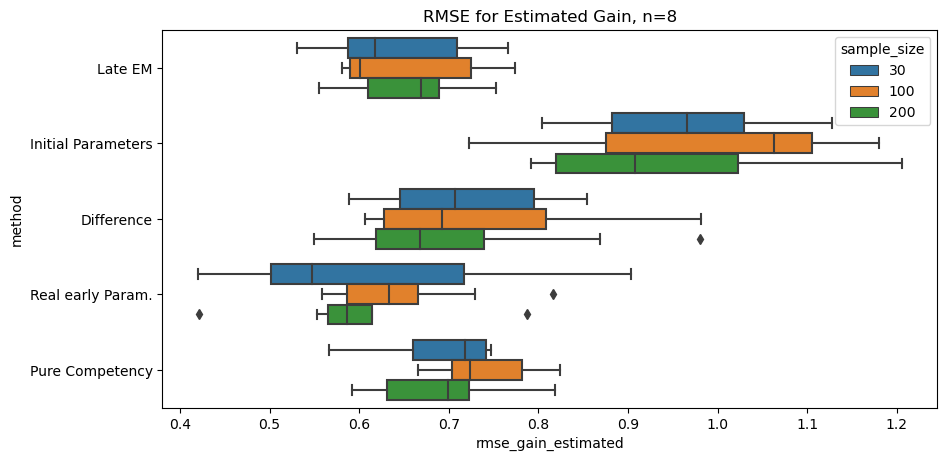

In [8]:
model_boxplot(full_Q_df, metric='rmse_gain_estimated', title="RMSE for Estimated Gain")

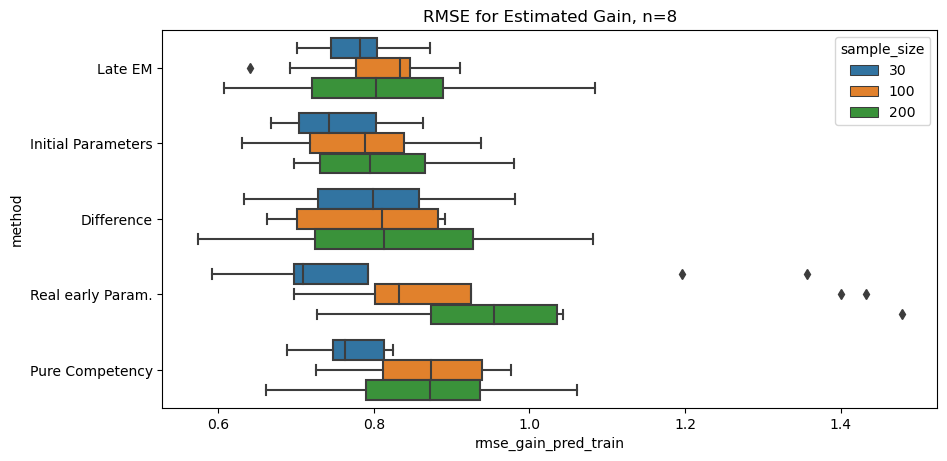

In [9]:
model_boxplot(full_Q_df, metric='rmse_gain_pred_train', title="RMSE for Estimated Gain")

### Seperated Q-Matrix

In [10]:
sep_Q_df = pd.read_csv("results/seperated_q.csv")
sep_Q_df

,latent_dimension,item_dimension,sample_size,key,method,early_runtime,late_runtime,early_steps,late_steps,early_l_optimal,...,rmse_early_A,rmse_early_delta,rmse_early_sigma,rmse_late_A,rmse_late_delta,rmse_psi,rmse_late_sigma,rmse_theta,rmse_gain_estimated,rmse_gain_pred_train
0,2,10,30,2022-11-09 14:13:59.977141,late_em,2.46,6.97,8.0,6.0,-165.55,...,0.871733,0.897408,0.230870,0.578739,0.421377,0.150137,0.111363,0.668068,0.648498,0.602380
1,2,10,30,2022-11-09 14:13:59.977141,initial,0.00,0.00,0.0,0.0,-165.68,...,0.822722,0.524366,0.353553,0.919626,0.556238,0.231157,0.353605,0.776873,0.986678,0.643375
2,2,10,30,2022-11-09 14:13:59.977141,difference,2.21,2.09,8.0,8.0,-165.82,...,0.804284,0.765525,0.269337,0.610905,0.354392,0.367587,0.275833,0.664686,0.983067,0.810406
3,2,10,30,2022-11-09 14:13:59.977141,real_early,NaN,8.16,NaN,7.0,NaN,...,NaN,NaN,NaN,0.507558,0.369690,0.185825,0.345257,0.000000,0.598543,0.713538
4,2,10,30,2022-11-09 14:13:59.977141,pure_competency,1.66,7.96,7.0,7.0,-165.73,...,0.844382,0.759816,0.000000,0.633343,0.352381,0.329273,0.587353,0.668640,0.846396,0.678724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1320,3,20,200,2022-11-09 17:29:08.421871,late_em,4.57,63.17,6.0,6.0,-2177.60,...,0.324554,0.261302,0.211879,0.226397,0.362822,0.421092,0.547955,0.703410,0.808644,0.865711
1321,3,20,200,2022-11-09 17:29:08.421871,initial,0.00,0.00,0.0,0.0,-2177.69,...,0.617583,0.349889,0.300489,0.918931,0.573969,0.278575,0.287937,0.771374,1.446046,0.796816
1322,3,20,200,2022-11-09 17:29:08.421871,difference,5.44,4.35,7.0,6.0,-2179.07,...,0.300354,0.263080,0.175595,0.220384,0.367540,0.258907,0.196257,0.695262,0.981375,0.862667
1323,3,20,200,2022-11-09 17:29:08.421871,real_early,NaN,68.90,NaN,6.0,NaN,...,NaN,NaN,NaN,0.160468,0.308058,0.446974,0.656306,0.000000,0.964133,1.028932


In [11]:
parameter_table_model(sep_Q_df, caption="Seperated Q-Matrix, Reference Model")

\begin{table}[H]
\centering
\caption{Seperated Q-Matrix, Reference Model, n=5}
\begin{tabular}{llrrrrrrr}
\toprule
    &                   &  $A^e$ &  $\Delta^e$ &  $\Sigma^e$ &  $A^l$ &  $\Delta^l$ &  $\Sigma^l$ &  $\Psi$ \\
\textbf{Sample size} & \textbf{Method} &        &             &             &        &             &             &         \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  1.011 &       0.683 &       0.068 &  1.310 &       1.252 &       0.359 &   0.354 \\
    & \textbf{Initial Parameters} &  0.659 &       0.451 &       0.098 &  0.896 &       0.895 &       0.391 &   0.290 \\
    & \textbf{Late EM} &  1.021 &       0.718 &       0.068 &  2.023 &       1.544 &       0.391 &   0.332 \\
    & \textbf{Pure Competency} &  0.913 &       0.750 &       0.274 &  1.691 &       1.621 &       0.618 &   0.447 \\
    & \textbf{Real early Param.} &    NaN &         NaN &         NaN &  2.150 &       1.267 &       0.391 &   0.421 \\
\cline{1-9}
\multirow{5}{*}{\te

C:\Users\Jesper\AppData\Local\Temp\ipykernel_19308\150259998.py:20: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(parameter_table.to_latex(bold_rows=True, multirow=True,


$A^e$  $\Delta^e$  $\Sigma^e$  $A^l$  \
Sample size Method                                                     
30          Difference          1.011       0.683       0.068  1.310   
            Initial Parameters  0.659       0.451       0.098  0.896   
            Late EM             1.021       0.718       0.068  2.023   
            Pure Competency     0.913       0.750       0.274  1.691   
            Real early Param.     NaN         NaN         NaN  2.150   
100         Difference          0.478       0.346       0.050  0.256   
            Initial Parameters  0.847       0.325       0.094  0.916   
            Late EM             0.478       0.337       0.050  0.274   
            Pure Competency     0.509       0.347       0.369  0.324   
            Real early Param.     NaN         NaN         NaN  0.343   
200         Difference          0.349       0.230       0.020  0.265   
            Initial Parameters  1.127       0.308       0.216  0.908   
            Late EM             0.375       0.215       0.030  0.249   
            Pure Competency     0.345       0.240       0.138  0.263   
            Real early Param.     NaN         NaN         NaN  0.263   

                                $\Delta^l$  $\Sigma^l$  $\Psi$  
Sample size Method                                              
30          Difference               1.252       0.359   0.354  
            Initial Parameters       0.895       0.391   0.290  
            Late EM                  1.544       0.391   0.332  
            Pure Competency          1.621       0.618   0.447  
            Real early Param.        1.267       0.391   0.421  
100         Difference               0.488       0.201   0.225  
            Initial Parameters       0.779       0.357   0.300  
            Late EM                  0.563       0.289   0.238  
            Pure Competency          0.412       0.619   0.368  
            Real early Param.        0.514       0.379   0.348  
200         Difference               0.340       0.143   0.338  
            Initial Parameters       0.809       0.354   0.270  
            Late EM                  0.323       0.312   0.291  
            Pure Competency          0.330       0.639   0.416  
            Real early Param.        0.314       0.330   0.220

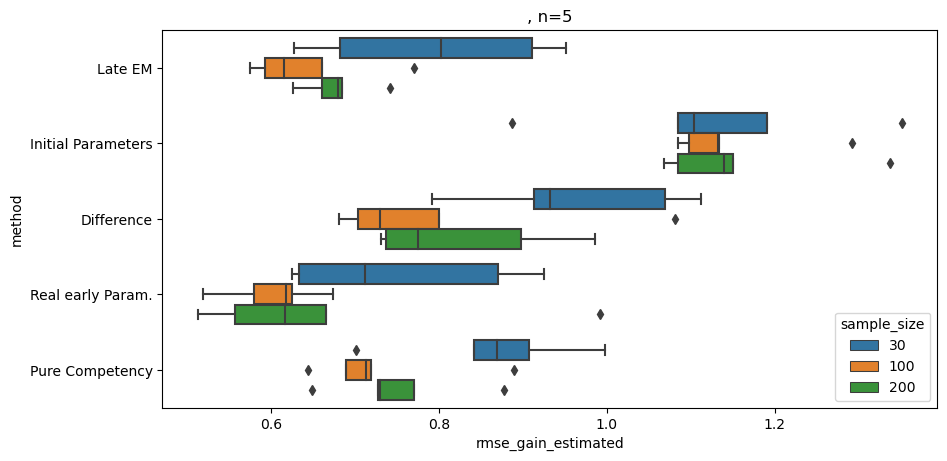

In [12]:
model_boxplot(sep_Q_df, metric='rmse_gain_estimated')

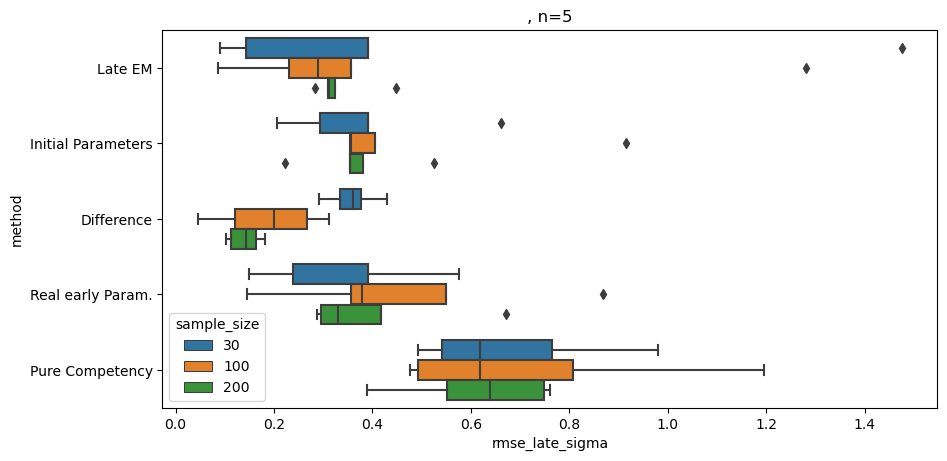

In [13]:
model_boxplot(sep_Q_df, metric='rmse_late_sigma')

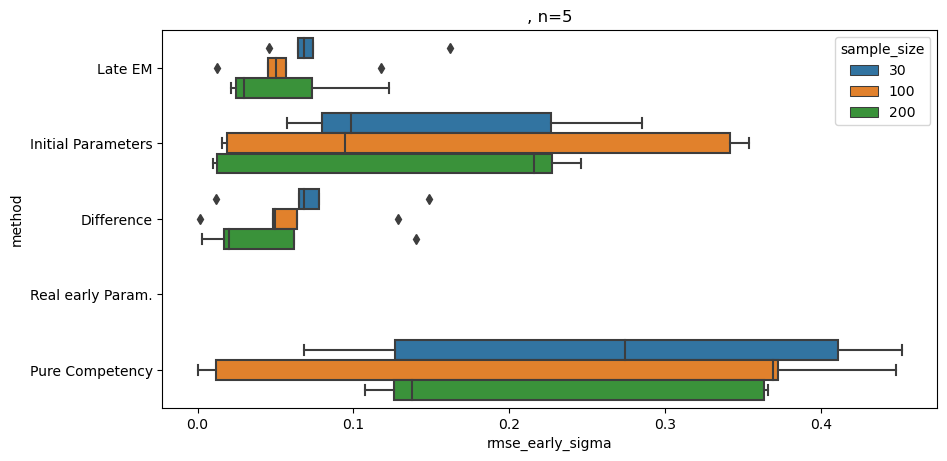

In [14]:
model_boxplot(sep_Q_df, metric='rmse_early_sigma')

### Pyramid Q-Matrix

In [15]:
pyramid_Q_df = pd.read_csv("results/pyramid_q.csv")
pyramid_Q_df

,latent_dimension,item_dimension,sample_size,key,method,early_runtime,late_runtime,early_steps,late_steps,early_l_optimal,...,rmse_early_A,rmse_early_delta,rmse_early_sigma,rmse_late_A,rmse_late_delta,rmse_psi,rmse_late_sigma,rmse_theta,rmse_gain_estimated,rmse_gain_pred_train
0,2,10,30,2022-11-09 17:35:17.900248,late_em,1.91,13.15,7.0,9.0,-165.71,...,1.596647,0.465094,0.000000,3.425927,3.166241,0.240945,0.374053,0.790489,0.739350,0.786535
1,2,10,30,2022-11-09 17:35:17.900248,initial,0.00,0.00,0.0,0.0,-166.23,...,1.629778,0.467686,0.353553,0.992341,1.115417,0.390831,0.384126,0.807575,0.961204,0.746710
2,2,10,30,2022-11-09 17:35:17.900248,difference,2.22,2.92,8.0,10.0,-165.83,...,1.710161,0.479138,0.000050,1.546724,1.558083,0.369769,0.226440,0.817012,0.928635,0.850655
3,2,10,30,2022-11-09 17:35:17.900248,real_early,NaN,7.36,NaN,6.0,NaN,...,NaN,NaN,NaN,2.518091,3.559138,0.482771,0.763990,0.000000,0.877311,0.954047
4,2,10,30,2022-11-09 17:35:17.900248,pure_competency,1.82,12.02,7.0,9.0,-165.61,...,1.614004,0.420618,0.000000,3.001575,2.919017,0.483658,0.687210,0.798692,0.899857,0.780534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,3,20,200,2022-11-09 22:52:16.599546,late_em,6.35,109.75,7.0,8.0,-1875.54,...,0.919388,0.302120,0.155194,0.792254,0.813577,0.252295,0.299479,0.613301,0.725456,0.872102
296,3,20,200,2022-11-09 22:52:16.599546,initial,0.00,0.00,0.0,0.0,-1873.99,...,1.608294,0.493561,0.333753,1.434783,1.407031,0.252301,0.299499,0.759959,1.224014,0.887221
297,3,20,200,2022-11-09 22:52:16.599546,difference,7.31,7.13,8.0,8.0,-1873.42,...,0.896023,0.317678,0.142570,0.826298,0.399761,0.238742,0.138670,0.608472,0.767908,0.862114
298,3,20,200,2022-11-09 22:52:16.599546,real_early,NaN,103.18,NaN,7.0,NaN,...,NaN,NaN,NaN,0.918357,1.277033,0.419103,0.476989,0.000000,0.817196,1.019666


In [16]:
parameter_table_model(full_Q_df, caption="Pyramid-Q-Matrix, RMSE Median of Parameter Recovery")

\begin{table}[H]
\centering
\caption{Pyramid-Q-Matrix, RMSE Median of Parameter Recovery, n=8}
\begin{tabular}{llrrrrrrr}
\toprule
    &                   &  $A^e$ &  $\Delta^e$ &  $\Sigma^e$ &  $A^l$ &  $\Delta^l$ &  $\Sigma^l$ &  $\Psi$ \\
\textbf{Sample size} & \textbf{Method} &        &             &             &        &             &             &         \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  2.389 &       1.624 &       0.069 &  1.969 &       1.789 &       0.226 &   0.248 \\
    & \textbf{Initial Parameters} &  1.442 &       0.585 &       0.104 &  1.391 &       1.431 &       0.354 &   0.307 \\
    & \textbf{Late EM} &  2.367 &       1.567 &       0.057 &  3.730 &       2.168 &       0.247 &   0.289 \\
    & \textbf{Pure Competency} &  2.449 &       1.628 &       0.249 &  2.534 &       2.450 &       0.561 &   0.362 \\
    & \textbf{Real early Param.} &    NaN &         NaN &         NaN &  4.574 &       2.781 &       0.474 &   0.353 \\
\cline{1-9}
\mu

C:\Users\Jesper\AppData\Local\Temp\ipykernel_19308\150259998.py:20: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(parameter_table.to_latex(bold_rows=True, multirow=True,


$A^e$  $\Delta^e$  $\Sigma^e$  $A^l$  \
Sample size Method                                                     
30          Difference          2.389       1.624       0.069  1.969   
            Initial Parameters  1.442       0.585       0.104  1.391   
            Late EM             2.367       1.567       0.057  3.730   
            Pure Competency     2.449       1.628       0.249  2.534   
            Real early Param.     NaN         NaN         NaN  4.574   
100         Difference          0.683       0.468       0.019  0.724   
            Initial Parameters  1.397       0.522       0.185  1.375   
            Late EM             0.699       0.466       0.018  0.863   
            Pure Competency     0.675       0.467       0.169  0.676   
            Real early Param.     NaN         NaN         NaN  0.799   
200         Difference          0.453       0.279       0.045  0.690   
            Initial Parameters  1.224       0.502       0.092  1.425   
            Late EM             0.464       0.304       0.056  0.829   
            Pure Competency     0.448       0.260       0.275  0.657   
            Real early Param.     NaN         NaN         NaN  1.015   

                                $\Delta^l$  $\Sigma^l$  $\Psi$  
Sample size Method                                              
30          Difference               1.789       0.226   0.248  
            Initial Parameters       1.431       0.354   0.307  
            Late EM                  2.168       0.247   0.289  
            Pure Competency          2.450       0.561   0.362  
            Real early Param.        2.781       0.474   0.353  
100         Difference               0.653       0.165   0.244  
            Initial Parameters       1.620       0.357   0.282  
            Late EM                  1.016       0.431   0.289  
            Pure Competency          1.470       0.721   0.411  
            Real early Param.        1.146       0.615   0.335  
200         Difference               0.491       0.147   0.216  
            Initial Parameters       1.534       0.390   0.286  
            Late EM                  1.002       0.424   0.244  
            Pure Competency          1.195       0.667   0.376  
            Real early Param.        0.960       0.483   0.355

In [17]:
single_metric_table(pyramid_Q_df, "rmse_psi", caption="RMSE for Correlations $\Psi$")

\begin{table}[H]
\centering
\caption{RMSE for Correlations $\Psi$, n=5}
\begin{tabular}{llrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     10 &     20 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  0.370 &  0.456 &  0.370 &  0.272 \\
    & \textbf{Initial Parameters} &  0.279 &  0.406 &  0.276 &  0.259 \\
    & \textbf{Late EM} &  0.241 &  0.261 &  0.360 &  0.259 \\
    & \textbf{Pure Competency} &  0.398 &  0.517 &  0.357 &  0.330 \\
    & \textbf{Real early Param.} &  0.224 &  0.414 &  0.368 &  0.306 \\
\cline{1-6}
\multirow{5}{*}{\textbf{100}} & \textbf{Difference} &  0.233 &  0.315 &  0.349 &  0.328 \\
    & \textbf{Initial Parameters} &  0.300 &  0.344 &  0.288 &  0.300 \\
    & \textbf{Late EM} &  0.332 &  0.363 &  0.253 &  0.318 \\
    & \textbf{Pure Competency} &  0.400 &  0.39

C:\Users\Jesper\AppData\Local\Temp\ipykernel_19308\1552858579.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True,


latent_dimension                    2             3       
item_dimension                     10     20     10     20
sample_size method                                        
30          Difference          0.370  0.456  0.370  0.272
            Initial Parameters  0.279  0.406  0.276  0.259
            Late EM             0.241  0.261  0.360  0.259
            Pure Competency     0.398  0.517  0.357  0.330
            Real early Param.   0.224  0.414  0.368  0.306
100         Difference          0.233  0.315  0.349  0.328
            Initial Parameters  0.300  0.344  0.288  0.300
            Late EM             0.332  0.363  0.253  0.318
            Pure Competency     0.400  0.397  0.397  0.379
            Real early Param.   0.290  0.344  0.407  0.303
200         Difference          0.307  0.243  0.250  0.270
            Initial Parameters  0.208  0.290  0.230  0.250
            Late EM             0.202  0.299  0.362  0.264
            Pure Competency     0.370  0.439  0.320  0.335
            Real early Param.   0.300  0.310  0.317  0.417

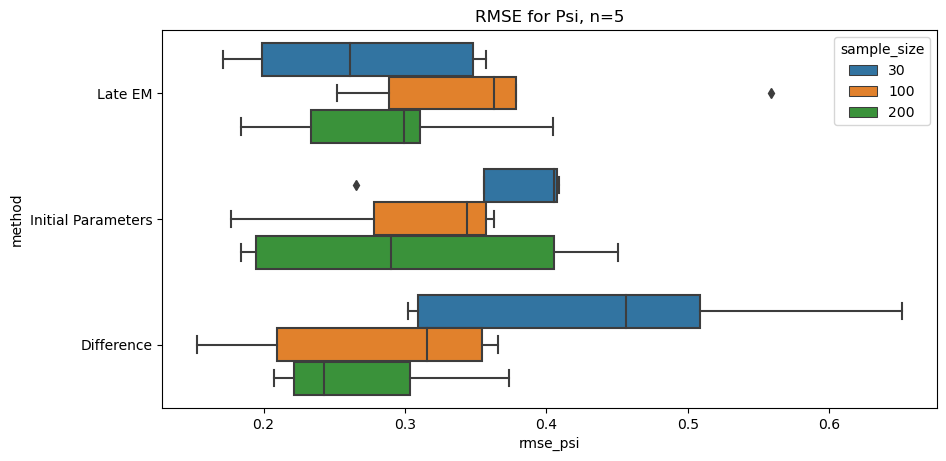

In [18]:
model_boxplot(pyramid_Q_df, metric="rmse_psi", methods=["late_em", "initial", "difference"], title="RMSE for Psi")

## Experiment 2: Prediction of Competency Gain

In [19]:
single_metric_table(full_Q_df, "rmse_theta", caption="Median RMSE for the estimation of $\\theta$")

\begin{table}[H]
\centering
\caption{Median RMSE for the estimation of $\theta$, n=4}
\begin{tabular}{llrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     10 &     20 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  0.687 &  0.537 &  0.742 &  0.590 \\
    & \textbf{Initial Parameters} &  0.672 &  0.551 &  0.720 &  0.606 \\
    & \textbf{Late EM} &  0.678 &  0.513 &  0.732 &  0.579 \\
    & \textbf{Pure Competency} &  0.718 &  0.531 &  0.758 &  0.595 \\
    & \textbf{Real early Param.} &  0.000 &  0.000 &  0.000 &  0.000 \\
\cline{1-6}
\multirow{5}{*}{\textbf{100}} & \textbf{Difference} &  0.604 &  0.444 &  0.617 &  0.505 \\
    & \textbf{Initial Parameters} &  0.617 &  0.546 &  0.661 &  0.570 \\
    & \textbf{Late EM} &  0.605 &  0.447 &  0.619 &  0.507 \\
    & \textbf{Pure Competency} & 

C:\Users\Jesper\AppData\Local\Temp\ipykernel_19308\1552858579.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True,


latent_dimension                    2             3       
item_dimension                     10     20     10     20
sample_size method                                        
30          Difference          0.687  0.537  0.742  0.590
            Initial Parameters  0.672  0.551  0.720  0.606
            Late EM             0.678  0.513  0.732  0.579
            Pure Competency     0.718  0.531  0.758  0.595
            Real early Param.   0.000  0.000  0.000  0.000
100         Difference          0.604  0.444  0.617  0.505
            Initial Parameters  0.617  0.546  0.661  0.570
            Late EM             0.605  0.447  0.619  0.507
            Pure Competency     0.627  0.444  0.621  0.544
            Real early Param.   0.000  0.000  0.000  0.000
200         Difference          0.593  0.444  0.591  0.498
            Initial Parameters  0.594  0.504  0.616  0.580
            Late EM             0.574  0.442  0.591  0.501
            Pure Competency     0.602  0.456  0.616  0.515
            Real early Param.   0.000  0.000  0.000  0.000

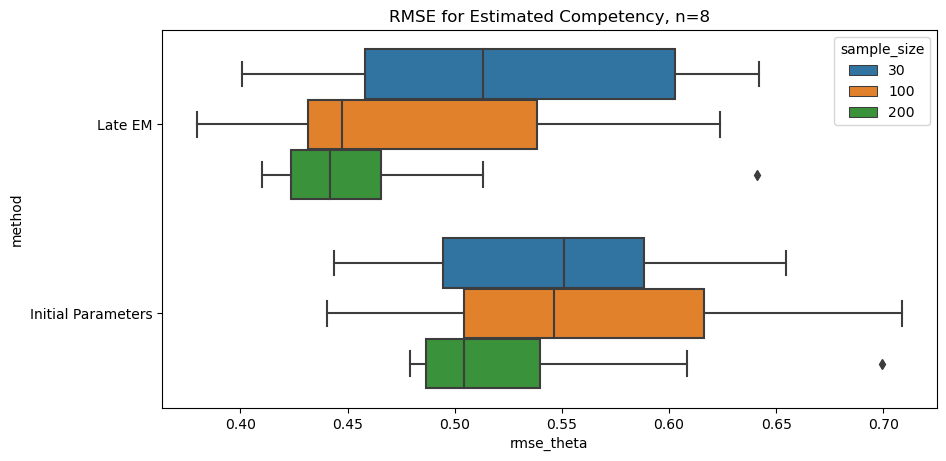

In [20]:
model_boxplot(full_Q_df, metric="rmse_theta", methods=["late_em", "initial"], title="RMSE for Estimated Competency")

In [21]:
single_metric_table(full_Q_df, "rmse_gain_estimated", caption="Median RMSE for Competency Gain Estimation")

\begin{table}[H]
\centering
\caption{Median RMSE for Competency Gain Estimation, n=4}
\begin{tabular}{llrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     10 &     20 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  0.925 &  0.707 &  0.936 &  0.864 \\
    & \textbf{Initial Parameters} &  0.938 &  0.966 &  1.079 &  1.126 \\
    & \textbf{Late EM} &  0.763 &  0.618 &  0.801 &  0.730 \\
    & \textbf{Pure Competency} &  0.792 &  0.718 &  0.838 &  0.774 \\
    & \textbf{Real early Param.} &  0.656 &  0.547 &  0.833 &  0.732 \\
\cline{1-6}
\multirow{5}{*}{\textbf{100}} & \textbf{Difference} &  0.859 &  0.692 &  0.852 &  0.826 \\
    & \textbf{Initial Parameters} &  0.964 &  1.063 &  1.104 &  1.102 \\
    & \textbf{Late EM} &  0.719 &  0.601 &  0.749 &  0.709 \\
    & \textbf{Pure Competency} & 

C:\Users\Jesper\AppData\Local\Temp\ipykernel_19308\1552858579.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True,


latent_dimension                    2             3       
item_dimension                     10     20     10     20
sample_size method                                        
30          Difference          0.925  0.707  0.936  0.864
            Initial Parameters  0.938  0.966  1.079  1.126
            Late EM             0.763  0.618  0.801  0.730
            Pure Competency     0.792  0.718  0.838  0.774
            Real early Param.   0.656  0.547  0.833  0.732
100         Difference          0.859  0.692  0.852  0.826
            Initial Parameters  0.964  1.063  1.104  1.102
            Late EM             0.719  0.601  0.749  0.709
            Pure Competency     0.798  0.724  0.795  0.767
            Real early Param.   0.652  0.633  0.781  0.673
200         Difference          0.785  0.668  0.905  0.789
            Initial Parameters  1.001  0.908  0.972  1.026
            Late EM             0.709  0.668  0.767  0.739
            Pure Competency     0.731  0.699  0.775  0.746
            Real early Param.   0.598  0.587  0.760  0.696

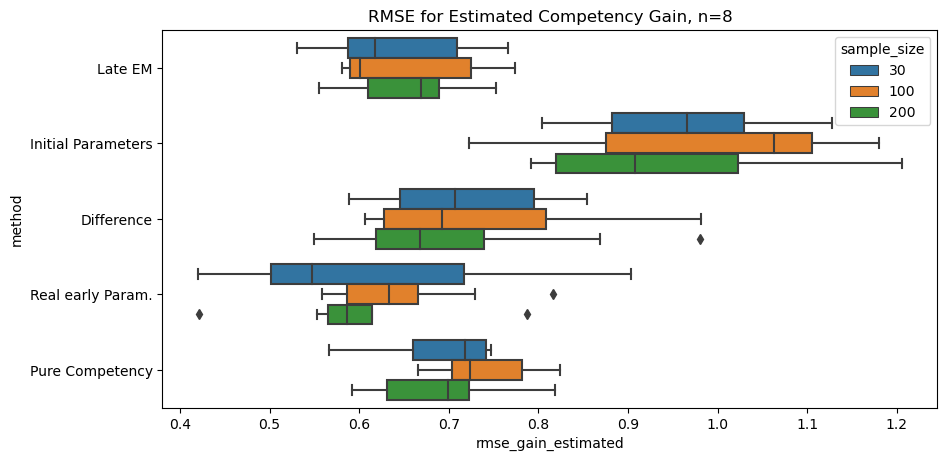

In [22]:
model_boxplot(full_Q_df, metric="rmse_gain_estimated", title="RMSE for Estimated Competency Gain")

In [23]:
single_metric_table(full_Q_df, "rmse_gain_pred_train", caption="Median RMSE for Competency Gain Prediction")

\begin{table}[H]
\centering
\caption{Median RMSE for Competency Gain Prediction, n=4}
\begin{tabular}{llrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     10 &     20 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  0.860 &  0.799 &  0.930 &  1.027 \\
    & \textbf{Initial Parameters} &  0.823 &  0.743 &  0.977 &  0.844 \\
    & \textbf{Late EM} &  0.846 &  0.782 &  0.998 &  0.840 \\
    & \textbf{Pure Competency} &  0.856 &  0.763 &  0.935 &  0.909 \\
    & \textbf{Real early Param.} &  0.803 &  0.709 &  1.074 &  0.979 \\
\cline{1-6}
\multirow{5}{*}{\textbf{100}} & \textbf{Difference} &  0.868 &  0.811 &  0.972 &  0.939 \\
    & \textbf{Initial Parameters} &  0.809 &  0.788 &  0.896 &  0.894 \\
    & \textbf{Late EM} &  0.816 &  0.834 &  0.908 &  0.888 \\
    & \textbf{Pure Competency} & 

C:\Users\Jesper\AppData\Local\Temp\ipykernel_19308\1552858579.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True,


latent_dimension                    2             3       
item_dimension                     10     20     10     20
sample_size method                                        
30          Difference          0.860  0.799  0.930  1.027
            Initial Parameters  0.823  0.743  0.977  0.844
            Late EM             0.846  0.782  0.998  0.840
            Pure Competency     0.856  0.763  0.935  0.909
            Real early Param.   0.803  0.709  1.074  0.979
100         Difference          0.868  0.811  0.972  0.939
            Initial Parameters  0.809  0.788  0.896  0.894
            Late EM             0.816  0.834  0.908  0.888
            Pure Competency     0.859  0.874  0.912  0.911
            Real early Param.   0.830  0.832  1.091  1.001
200         Difference          0.814  0.813  0.975  0.866
            Initial Parameters  0.791  0.796  0.899  0.847
            Late EM             0.779  0.803  0.937  0.866
            Pure Competency     0.802  0.873  0.900  0.922
            Real early Param.   0.773  0.954  1.029  0.877

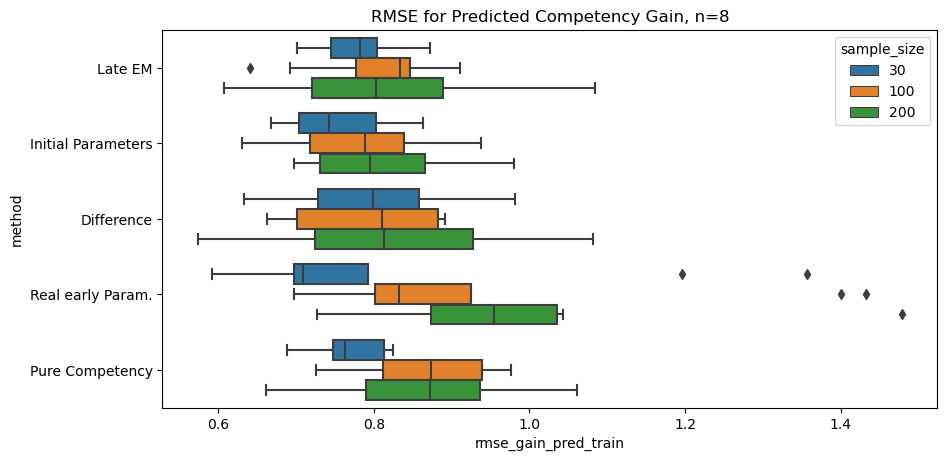

In [24]:
model_boxplot(full_Q_df, metric="rmse_gain_pred_train", title="RMSE for Predicted Competency Gain")

### CSEDM Data
base: uirt_lfa_model_csedm_final.ipynb

In [25]:
import pandas as pd
import numpy as np
from ProgSnap2 import ProgSnap2Dataset
from ProgSnap2 import PS2
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import time
import os
from os import path
import sys
sys.path.append(os.path.realpath("./models"))
sys.path.append(os.path.realpath("./em_algorithm"))
# Custom modules, import violates pep8, so we have to declare an exeption
if True:  # noqa: E402
    from mirt_2pl import mirt_2pl
    from mirt_2pl_gain import mirt_2pl_gain
    from e_step_mirt_2pl import e_step_ga_mml
    from e_step_mirt_2pl_gain import e_step_ga_mml_gain
    from m_step_mirt_2pl import m_step_ga_mml
    from m_step_mirt_2pl_gain import m_step_ga_mml_gain
    from em_algorithm import em_algo

In [26]:
semester = 'F19'
BASE_PATH = os.path.join('C:/Users/Jesper/Google Drive/Uni docs/Statistik/Masterarbeit/Daten/csedm_challenge_dataset', 'F19_Release_Train_06-28-21')
TRAIN_PATH = os.path.join(BASE_PATH, 'Train')

In [27]:
#Dataset for early Problem Performance (Aggregated from Event-Data)
early = pd.read_csv(os.path.join(TRAIN_PATH, 'early.csv'))
early["alt_Label"] = early.apply(lambda x: 1 if (x["CorrectEventually"] and x["Attempts"] <= 3) else 0, axis=1)
early

late = pd.read_csv(os.path.join(TRAIN_PATH, 'late.csv'))

In [28]:
from sklearn.impute import KNNImputer

#Obtain Matrix of Response-vectors
U = pd.crosstab(index = early["SubjectID"], 
            columns=[early["AssignmentID"], early["ProblemID"]], 
            values=early["Label"],
            aggfunc="sum")
#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
imputer = KNNImputer(n_neighbors=4)
U = imputer.fit_transform(U).round()
U = pd.DataFrame(U)

#Obtain Matrix of Response-vectors
V = pd.crosstab(index = late["SubjectID"], 
            columns=[late["AssignmentID"], late["ProblemID"]], 
            values=late["Label"],
            aggfunc="sum")
#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
#late_U = late_U.dropna()

imputer = KNNImputer(n_neighbors=4)
V = imputer.fit_transform(V).round()
V = pd.DataFrame(V)


In [29]:
#Source: https://docs.google.com/spreadsheets/d/1-APxPAVP3PylM0fskzDNgpalj1DTuMqDLkgBC5QxJdg/edit#gid=0
item_skill_df = pd.read_csv("CSEDM Challenge/item_skill_relation.csv")
item_skill_df.columns

Index(['AssignmentID', 'ProblemID', 'Requirement', 'If/Else', 'NestedIf',
       'While', 'For', 'NestedFor', 'Math+-*/', 'Math%', 'LogicAndNotOr',
       'LogicCompareNum', 'LogicBoolean', 'StringFormat', 'StringConcat',
       'StringIndex', 'StringLen', 'StringEqual', 'CharEqual', 'ArrayIndex',
       'DefFunction'],
      dtype='object')

In [30]:
logic_skills = ['If/Else', 'NestedIf', 'LogicAndNotOr', 'LogicCompareNum', 'LogicBoolean']
string_skills = ['StringFormat', 'StringConcat', 'StringIndex', 'StringLen', 'StringEqual', 'CharEqual']
iter_skills = ['While', 'For', 'NestedFor', 'ArrayIndex']

logic_exercises = (np.sum(item_skill_df[logic_skills], axis=1) > 0)
string_exersises = (np.sum(item_skill_df[string_skills], axis=1) > 0)
iter_exercises = (np.sum(item_skill_df[iter_skills], axis=1) > 0)

full_Q = np.stack((logic_exercises, iter_exercises), axis=1)
early_Q = full_Q[0:30,:]
late_Q = full_Q[30:50, :]

In [31]:
# Fit early Model
early_model = mirt_2pl(latent_dimension=2, item_dimension=U.shape[1], Q=early_Q)
early_model.initialize_from_responses(response_data=U)
e_step = e_step_ga_mml(model=early_model)
m_step = m_step_ga_mml(
    early_model, sigma_constraint="early_constraint")
em = em_algo(e_step=e_step, m_step=m_step, model=early_model)


start_time = time.time()
em.fit([U.reset_index(drop=True)], max_iter=30,
        stop_threshold=0.001, person_method="BFGS")
run_time = (time.time() - start_time)
theta_hat = early_model.predict_competency(U)
estimated_early_item_parameters = em.model.item_parameters
estimated_early_person_parameters = em.model.person_parameters

EM Iteration 2


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 300
Step: 2: current parameter_diff: 7.681067664979868, current marginal loglikelihood: -5625.47600622357
EM Iteration 3


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 300
Step: 3: current parameter_diff: 5.220576374504292, current marginal loglikelihood: -5596.043829255184
EM Iteration 4
Current Monte Carlo Sample size: 324
Step: 4: current parameter_diff: 4.032774272562575, current marginal loglikelihood: -5584.724196494348
EM Iteration 5
Current Monte Carlo Sample size: 349
Step: 5: current parameter_diff: 1.9814710803755204, current marginal loglikelihood: -5582.910259791057
EM Iteration 6
Current Monte Carlo Sample size: 349
Step: 6: current parameter_diff: 1.2320845095971242, current marginal loglikelihood: -5576.034753870593
EM Iteration 7
Current Monte Carlo Sample size: 349
Step: 7: current parameter_diff: 1.0769566680420153, current marginal loglikelihood: -5577.794116313211
EM Iteration 8
Current Monte Carlo Sample size: 376
Step: 8: current parameter_diff: 0.7189341032165424, current marginal loglikelihood: -5580.823244450756
EM Iteration 9
Current Monte Carlo Sample size: 406
Step: 9: current parameter_di

In [32]:
# Estimate the Late Variance


In [35]:
#Fit late Model
# Initialize Model
late_model = mirt_2pl_gain(item_dimension=20, latent_dimension=2, mu=1,
                            early_sigma=estimated_early_person_parameters["covariance"],
                            Q=late_Q)
# TODO: Check if theta_hat can be used
late_model.initialize_from_responses(
    late_response_data=V, early_response_data=U,
    logit=True, sigma=False)
late_initial_parameters = late_model.get_parameters()
e_step = e_step_ga_mml_gain(
    model=late_model)
m_step = m_step_ga_mml_gain(
    late_model, sigma_constraint="early_constraint")
em = em_algo(e_step=e_step, m_step=m_step, model=late_model)

# Fit late model
start_time = time.time()
em.fit([V, pd.DataFrame(theta_hat)], max_iter=30,
        stop_threshold=0.01, person_method="BFGS")
run_time = (time.time() - start_time)
s_hat = late_model.predict_gain(
    V, pd.DataFrame(theta_hat))

s_pred_train = late_model.predict_gain(
    theta=pd.DataFrame(theta_hat))


EM Iteration 2


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 300
Step: 2: current parameter_diff: 15.316731053708994, current marginal loglikelihood: -4388.1934722085225
EM Iteration 3


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 300
Step: 3: current parameter_diff: 15.546695318428252, current marginal loglikelihood: -4308.945473532111
EM Iteration 4


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 324
Step: 4: current parameter_diff: 12.659906171045819, current marginal loglikelihood: -4238.584898057168
EM Iteration 5


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 349
Step: 5: current parameter_diff: 10.176842909329284, current marginal loglikelihood: -4221.751283602607
EM Iteration 6


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 349
Step: 6: current parameter_diff: 7.036951912282921, current marginal loglikelihood: -4248.609813055852
EM Iteration 7


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 376
Step: 7: current parameter_diff: 9.013442810859413, current marginal loglikelihood: -4204.158583259397
EM Iteration 8


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 406
Step: 8: current parameter_diff: 5.089076181803777, current marginal loglikelihood: -4190.928064809696
EM Iteration 9


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 438
Step: 9: current parameter_diff: 6.482547519455441, current marginal loglikelihood: -4200.844389386189
EM Iteration 10


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 473
Step: 10: current parameter_diff: 8.45047131027558, current marginal loglikelihood: -4193.014876297612


In [ ]:
U.shape

(367, 30)

In [46]:
V.shape

(367, 20)